# Calcim GAN

This tutorial will provide an introduction to using recent deep learning methods for analyzing data beyond simple classification problems. In particular, we will look at how to build a generative model to characterize the "spike inferrence" task common in calcium imaging. This tutorial will use the [Spikefinder](http://spikefinder.codeneuro.org/) dataset, which contains a collection of calcium imaging fluorescences and the associated observed spikes.

In [1]:
# First, let's load all the dependencies we will need.
# The utils module contains all the functions for loading
# and processing data; this tutorial will focus on building
# the deep learning models.

from __future__ import division
from __future__ import print_function

import os
import sys

from imp import reload
import utils; reload(utils)

import keras
import numpy as np
import matplotlib.pyplot as plt

# Checks that you've got Keras 2.0.0 installed (for compatibility).
assert keras.__version__ == '2.0.0', 'Invalid Keras version.'

Using TensorFlow backend.


Let's use matplotlib to plot samples from the data.

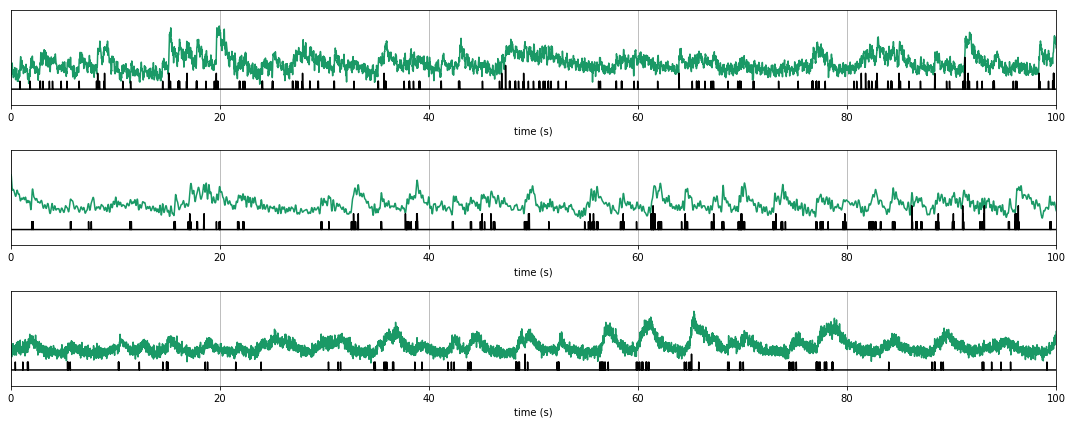

In [2]:
def plot_sample(calcium=None,
                spikes=None,
                t_start=0,
                t_end=100,
                sampling_rate=100):
    """Plots samples of calcium and spikes.

    Args:
        calcium: 1D Numpy float array containing the calcium fluorescences
            (each entry is the average fluorescence in that time bin).
        spikes: 1D Numpy float array containing the
            spike data (each entry is the number of spikes in that time bin).
        t_start: float (default: 0), the start time, in seconds.
        t_end: float (default: 100), the end time, in seconds.
        sampling_rate: float (default: 100), the sampling rate.
    """
    
    if calcium is None and spikes is None:
        raise ValueError('Must pass at least one of `calcium` or `spikes`.')

    panel = [t_start, t_end]
    x_len = len(calcium) if calcium is not None else len(spikes)
    x = np.arange(x_len) / sampling_rate
    if calcium is not None:
        plt.plot(x, calcium, color=(.1, .6, .4))
    if spikes is not None:
        plt.plot(x, spikes / 2.0 - 1, color='k')
    plt.yticks([])
    plt.ylim([-2., 4.])
    plt.xlim(panel)
    plt.ylabel('')
    plt.xlabel('time (s)')
    plt.grid()

# Plots the first 5 samples.
fig = plt.figure(figsize=(15, 6))
for i, (c, s) in zip(range(1, 4), utils.iterate_files()):
    plt.subplot(3, 1, i)
    plot_sample(c['0'], s['0'])

plt.tight_layout()
plt.show()

del i, c, s

Now that we've got an idea of what the data looks like, let's parse a dataset. We will partition the calcium fluorescences into two parts: the part where there is at least one spike in an N-bin range, and the part where there isn't.

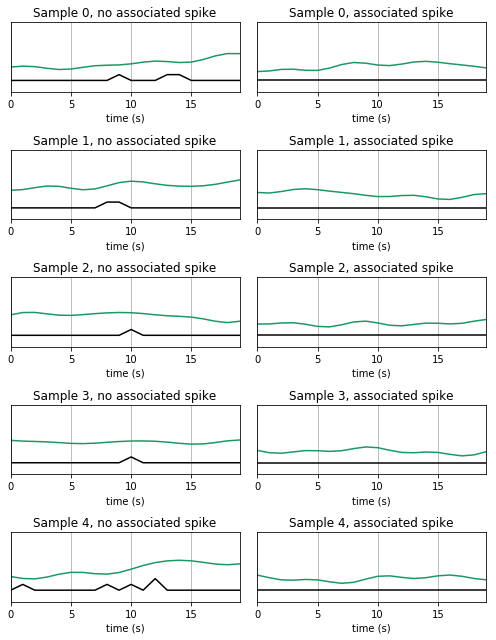

In [3]:
def partition_data(len_pre, len_post=None, spike_n=2, skip=10, iterate=False):
    """Partitions the data into spike-eliciting and non-spike-eliciting.
    
    This will return two lists, the calcium data and the spikes list. The
    calcium data is a list of 1D Numpy arrays, corresponding to the calcium
    fluorescences around the spike in question. The spikes list contains
    boolean values saying whether or not there was a spike in the `spike_n`
    bins directly before or after the current timestep.

    Args:
        len_pre: int, the number of bins before the current spike to include.
        len_post: int (default: None, the number of bins after the current
            spike to include. If it isn't set, it defaults to len_pre.
        spike_n: int (default: 2), the number of timesteps forward and
            backward to look for whether or nor a spike was produced.
        skip: int (default: 10), the number of bins to skip on each step.
        iterate: if set, instead of returning lists, iterates through the data.
    
    Yields:
        calcium: a 1D Numpy arrays, the calcium fluorescence windows.
        spikes: a 1D Numpy array, the spiking window.
        did_spike: a boolean values, whether or not there was a spike
            associated with that particular calcium window.
    """
    
    if len_post is None:
        len_post = len_pre

    for calcium_df, spikes_df in utils.iterate_files():
        for column in calcium_df:
            calcium_col = calcium_df[column].dropna()
            spikes_col = spikes_df[column].dropna()
            
            # Walk through each column, getting the data window.
            for i in range(len_pre, len(calcium_col) - len_post, skip):
                did_spike = any(spikes_col[i-spike_n:i+spike_n])
                spikes = spikes_col[i-len_pre:i+len_post]
                calcium = calcium_col[i-len_pre:i+len_post]
                
                yield calcium, spikes, did_spike

# Gets five examples of each type.
yes_cal, no_cal, yes_spikes, no_spikes = [], [], [], []
for calcium, spikes, did_spike in partition_data(10, spike_n=1):
    if did_spike:
        yes_cal.append(calcium)
        yes_spikes.append(spikes)
    else:
        no_cal.append(calcium)
        no_spikes.append(spikes)
    
    if len(yes_spikes) > 5 and len(no_spikes) > 5:
        break

# Plot the data where no spike was observed on the left,
# and the data where a spike was observed on the right.
fig = plt.figure(figsize=(7, 9))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plot_sample(yes_cal[i], yes_spikes[i], t_start=0, t_end=19, sampling_rate=1)
    plt.title('Sample %d, no associated spike' % i)
    plt.subplot(5, 2, 2 * i + 2);
    plot_sample(no_cal[i], no_spikes[i], t_start=0, t_end=19, sampling_rate=1)
    plt.title('Sample %d, associated spike' % i)

plt.tight_layout()
plt.show()

del yes_cal, no_cal, yes_spikes, no_spikes

Great! Now we've got a way of splitting the dataset into "spike observed" and "no spike observed" points. Let's split all the data up this way, and put them in Numpy arrays so that we can build our model. Since we just care about whether or not a spike was observed at the current timestep, we'll ignore the spike trace. Additionally, let's cache the Numpy arrays somewhere on disk so that we don't have to worry about regenerating the dataset every time we want to use it (since this operation can be kind of slow).

In [4]:
def load_dataset(cache='spikefinder.data.npz'):
    """Loads the dataset, caching it in `cache`.
    
    This dataset uses parameters that have been set for this particular task.
    These parameters can be altered depending on the application.

    Args:
        cache: str (default: "spikefinder.data.npz"), where to cache the
            dataset once it is created.
    """
    
    if cache and os.path.exists(cache):  # Loads the cached version, if it exists.
        data = np.load(cache)
        return data['calcium'], data['did_spike']
    
    calcium_list, did_spike_list = [], []
    for i, (calcium, _, did_spike) in enumerate(partition_data(50, spike_n=2, skip=10)):
        calcium_list.append(calcium)
        did_spike_list.append(did_spike)
        if i % 1000 == 0:
            sys.stderr.write('\rprocessed %d samples' % i)
            sys.stderr.flush()
    sys.stderr.write('\rprocessed %d samples' % len(calcium_list))
    
    calcium_data = np.asarray(calcium_list)
    did_spike_data = np.asarray(did_spike_list)
    
    with open(cache, 'wb') as f:
        np.savez(f, calcium=calcium_data, did_spike=did_spike_data)
    
    return calcium_data, did_spike_data

calcium, did_spike = load_dataset()
print('Size of the dataset:')
print('    calcium: %d samples of length %d' % (calcium.shape[0], calcium.shape[1]))
print('    did_spike: %d samples' % did_spike.shape[0])

del calcium, did_spike

Size of the dataset:
    calcium: 514860 samples of length 20
    did_spike: 514860 samples


Great, now all of our data preprocessing is done. Let's get into the specifics of the model. We're going to try out two types of generative deep neural networks. The first (and more intuitive) is a [Variational Autoencoder](https://arxiv.org/abs/1606.05908). The second is a [Generative Adversarial Network](https://arxiv.org/abs/1406.2661).

## Autoencoders

An autoencoder is simply a neural network that learns to reconstruct its own inputs. Typically, it learns a mapping to a low-dimensional space, then it learns to take that mapping and reproduce the original data. The simplest example of an autoencoder is Principal Component Analysis; the principal components represent orthogonal manifolds in the data, where the first principal component has the highest variance, the second has the second most variance, and so on. Taking the top-N principal components is a way of doing "dimensionality reduction" on the data. Conceptually, this process captures common features of the dataset. Neural network autoencoders do much the same thing. The diagram below shows the structure of an autoencoder.

![Autoencoder diagram from Wikipedia](resources/autoencoder_structure_wikipedia.png)

The **latent vector** $Z$ in the autoencoder represents the low-dimensional representation of the data $X$.

## Variational Autoencoders

Variational autoencoders and an interesting extension to regular autoencoders. Suppose the latent vector $Z$ is a normally-distributed random variable. After training, the entire vector space of $Z$ will (hopefully) correspond to viable reconstructions of real data. In other words, we could feed our own vector into the decoder neural network, and get a reconstruction back out.

To do this, we just need to make sure the latent vector is normally distributed. We apply a penalty to minimize the KL divergence between $Z$ and a normal distribution. KL divergence is simply a measure of how different two distributions are:

$$D_{KL} (P \Vert Q) = \int_{-\infty}^{\infty} p(x) \log \frac{p(x)}{q(x)} dx$$

Given a latent vector with mean $\mu$ and variance $\sigma^2$, we apply the penalty

$$C_{KL} = -\frac{1 + \sigma - \mu^2 - e^{\sigma}}{2}$$

to push the latent vector towards a normal distribution.

## Building the model

Let's build a very simple autoencoder model using Keras and train it on some sample data. Our autoencoder will be slightly different from a conventional autoencoder, because we also want the encoder and decoder to have access to information about whether or not the calcium fluorescence trace that we are feeding it corresponds to an illicited spike.

The first thing we need to do is add a new layer to represent the variational part. To do this, we'll reference the variational autoencoder example in the Keras examples directory [here](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py). We'll also add some extra layers that we can use later.

In [87]:
# We need to input the "backend", which is a stand-in for Tensorflow
# or Theano, to perform special matrix operations.
import keras.backend as K


class DeltaFeature(keras.layers.Layer):
    """Layer for calculating time-wise deltas."""

    def build(self, input_shape):
        if len(input_shape) != 3:
            raise ValueError('DeltaFeature input should have three '
                             'dimensions. Got %d.' % len(input_shape))
        super(DeltaFeature, self).build(input_shape)

    def call(self, x, mask=None):
        x_a, x_b = K.zeros_like(x[:, 1:]), x[:, :1]
        x_shifted = K.concatenate([x_a, x_b], axis=1)
        return x - x_shifted

    def get_output_shape_for(self, input_shape):
        return input_shape


class QuadFeature(keras.layers.Layer):
    """Layer for calculating quadratic feature (square inputs)."""

    def call(self, x, mask=None):
        return K.square(x)

    def get_output_shape_for(self, input_shape):
        return input_shape

    
class NormalizeOverTime(keras.layers.Layer):
    """Normalizes over the time axis."""
    
    def call(self, x, mask=None):
        std = K.std(x, axis=1, keepdims=True) + 1e-12
        return (x - K.mean(x, axis=1, keepdims=True)) / std
    
    def get_output_shape_for(self, input_shape):
        return input_shape


class VariationalLayer(keras.layers.Layer):
    """A Dense layer that outputs a normally distributed vector."""
    
    def __init__(self, output_dim, epsilon_std=1., **kwargs):
        self.output_dim = output_dim
        self.epsilon_std = epsilon_std
        super(VariationalLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.z_mean_kernel = self.add_weight(
            shape=(input_shape[1], self.output_dim),
            initializer='glorot_normal',
            trainable=True)
        self.z_mean_bias = self.add_weight(
            shape=(self.output_dim,),
            initializer='zero',
            trainable=True)
        self.z_log_var_kernel = self.add_weight(
            shape=(input_shape[1], self.output_dim),
            initializer='glorot_normal',
            trainable=True)
        self.z_log_var_bias = self.add_weight(
            shape=(self.output_dim,),
            initializer='zero',
            trainable=True)
        
        super(VariationalLayer, self).build(input_shape)
    
    def call(self, x):
        z_mean = K.dot(x, self.z_mean_kernel) + self.z_mean_bias
        z_log_var = K.dot(x, self.z_log_var_kernel) + self.z_log_var_bias
        epsilon = K.random_normal(shape=K.shape(z_log_var),
                                  mean=0.,
                                  stddev=self.epsilon_std)
        
        # Computes variational loss.
        kl_inside = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        self.kl_loss = -0.5 * K.sum(kl_inside, axis=-1)

        # Samples from the distribution to get the output tensor.
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    def loss(self, variational_weight=1.):
        """A loss function that can be used by a Keras model."""
        
        loss = keras.losses.mean_squared_error
        
        def variational_loss(x, x_rec):
            return loss(x, x_rec) + self.kl_loss * variational_weight
        
        return variational_loss
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'epsilon_std': self.epsilon_std,
            'loss': self
        }
        base_config = super(VariationalLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

This layer calculates the KL divergence loss for us, and provides a loss function that combines it with mean squared reconstruction error. Let's train this on some toy data to visualize what it is doing.

In [6]:
NUM_LATENT_DIMS = 2
variational = VariationalLayer(NUM_LATENT_DIMS)

# Builds the encoder model.
input_var = keras.layers.Input(shape=(10,))
x = keras.layers.Dense(20, activation='tanh')(input_var)
x = variational(x)
encoder = keras.models.Model(input_var, x)

# Builds the decoder model.
input_var = keras.layers.Input(shape=(NUM_LATENT_DIMS,))
x = keras.layers.Dense(20, activation='tanh')(input_var)
x = keras.layers.Dense(20, activation='tanh')(x)
x = keras.layers.Dense(10)(x)
decoder = keras.models.Model(input_var, x)

# Builds the trainable model.
input_var = keras.layers.Input(shape=(10,))
trainable_model = keras.models.Model(inputs=input_var,
                                     outputs=decoder(encoder(input_var)))
trainable_model.compile(loss=variational.loss(1e-2),
                        optimizer='adam',
                        metrics=['accuracy'])

# The toy data will be random one-hot encoded values.
idxs = np.random.randint(0, 10, size=(10000))
toy_distribution = np.eye(10)[idxs]

# To train the autoencoder, train distribution -> distribution.
trainable_model.fit(toy_distribution, toy_distribution,
                    epochs=10, verbose=2, batch_size=32)

print('Done training the model.')

Epoch 1/10
0s - loss: 0.0998 - acc: 0.1307
Epoch 2/10
0s - loss: 0.0889 - acc: 0.2117
Epoch 3/10
0s - loss: 0.0858 - acc: 0.3545
Epoch 4/10
0s - loss: 0.0798 - acc: 0.5236
Epoch 5/10
0s - loss: 0.0737 - acc: 0.6328
Epoch 6/10
0s - loss: 0.0659 - acc: 0.7775
Epoch 7/10
0s - loss: 0.0582 - acc: 0.8895
Epoch 8/10
0s - loss: 0.0527 - acc: 0.9356
Epoch 9/10
0s - loss: 0.0492 - acc: 0.9639
Epoch 10/10
0s - loss: 0.0464 - acc: 0.9806
Done training the model.


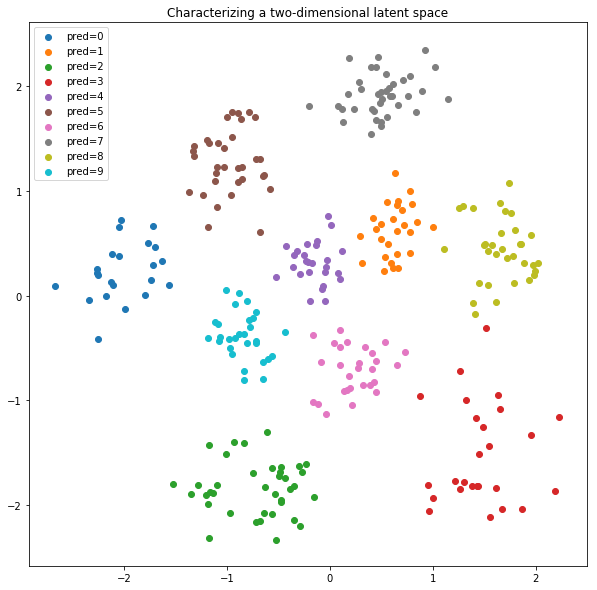

In [7]:
# Uses the decoder to sample from the data distribution.
idxs = np.random.randint(0, 10, size=(300))
inputs = np.eye(10)[idxs]
preds = encoder.predict(inputs)

# Maps the latent space to the predict outputs.
plt.figure(figsize=(10, 10))
for i in range(10):
    ith_preds = preds[idxs == i]
    plt.scatter(ith_preds[:, 0], ith_preds[:, 1], label='pred=%d' % i)
plt.legend(loc=2)
plt.title('Characterizing a two-dimensional latent space')
plt.show()

As we hoped, the latent dimension clusters the data according to what we want to reconstruct.

Now that we've got a variational layer, we can build our model. This model will be a bit more complicated than the one from above, but fundamentally basically the same. We want to feed it the additional spike / no-spike information, so we'll give that information to the encoder and the decoder.

In [90]:
def check_built(f):
    """A simple wrapper that checks if the model is built, and if not builds it."""
    
    def wrapper(self, *args, **kwargs):
        if not hasattr(self, '_built') or not self._built:
            self.build()
            self._built = True
        return f(self, *args, **kwargs)
    return wrapper


class VariationalAutoencoder(object):
    """A Variational Autoencoder to approximate the spikefinder data."""
    
    def __init__(self, num_input, num_latent=100):
        """Initializes the autoencoder parameters.
        
        Args:
            num_input: int, the number of dimensions in the dataset
                you are trying to approximate.
            num_latent: int, the number of latent dimensions to
                map the data to.
        """
        
        self._num_input = num_input
        self._num_latent = num_latent
        
        # Initializes placeholders for the encoder and decoder models.
        self._encoder, self._decoder, self._encoder_decoder = None, None, None
    
    @property
    def num_input(self):
        return self._num_input
    
    @property
    def num_latent(self):
        return self._num_latent
    
    def build(self, encoder_dims=[128, 128], decoder_dims=[128, 128]):
        """Builds the encoder and decoder models."""
        
        input_calcium = keras.layers.Input(shape=(self.num_input,), name='input_calcium')
        input_spikes = keras.layers.Input(shape=(1,), name='input_spikes')
        latent_vec = keras.layers.Input(shape=(self.num_latent,), name='latent_vec')
        variational_layer = VariationalLayer(self.num_latent)
        
        # Builds the encoder.
        calcium_rep = keras.layers.Reshape((self.num_input, 1))(input_calcium)
        calcium_delta = DeltaFeature()(calcium_rep)
        calcium_quad = QuadFeature()(calcium_rep)
        spikes_rep = keras.layers.RepeatVector(self.num_input)(input_spikes)
        x = keras.layers.Concatenate()([calcium_rep, calcium_delta, calcium_quad, spikes_rep])
        x = NormalizeOverTime()(x)
        x = keras.layers.LSTM(64, return_sequences=False)(x)
        variational_output = variational_layer(x)
        self._encoder = keras.models.Model(inputs=[input_calcium, input_spikes],
                                           outputs=variational_output)
        
        # Builds the decoder.
        spikes_pl = keras.layers.Input(shape=(1,), name='spikes_pl')
        x = keras.layers.Concatenate()([latent_vec, spikes_pl])
        x = keras.layers.RepeatVector(self.num_input)(x)
        x = keras.layers.LSTM(64, return_sequences=True)(x)
        x = keras.layers.Dense(1)(x)
        calcium_pred = keras.layers.Reshape((self.num_input,))(x)
        self._decoder = keras.models.Model(inputs=[latent_vec, spikes_pl],
                                           outputs=[calcium_pred])
        
        output_calcium = self._decoder([variational_output, input_spikes])
        self._encoder_decoder = keras.models.Model(inputs=[input_calcium, input_spikes],
                                                   outputs=[output_calcium])
        self._encoder_decoder.compile(loss=variational_layer.loss(1e-4),
                                      optimizer='adam',
                                      metrics={'did_spike': 'accuracy'})
        
    @check_built
    def sample(self, num_samples=None, latent_vec=None, did_spike=False):
        """Produces samples from the model by feeding the decoder a random vector.
        
        Args:
            num_samples: int (default: None), number of samples to produce
                from the model, if .
            latent_vec: a 2D Numpy array to use instead of generating a new one.
            did_spike: bool (default: False), whether or not to tell the model
                to produce calcium samples associated with a spike.
        
        Returns:
            calcium_pred: 2D Numpy array with shape (num_samples, num_inputs),
                the predicted calcium trace.
        """
        
        if latent_vec is None:
            assert num_samples is not None, 'Must specifiy `num_samples`.'
            latent_vec = np.random.normal(loc=0., scale=1.,
                                          size=(num_samples, self.num_latent))
        else:
            num_samples = latent_vec.shape[0]
        
        spikes_arr = np.asarray([1. if did_spike else 0.] * num_samples)
        calcium_pred = self._decoder.predict([latent_vec, spikes_arr])
        return calcium_pred
    
    @check_built
    def predict(self, calcium, spikes):
        """Gets model predictions on some input data.
        
        Args:
            calcium: 2D Numpy array with shape (sample_dim, num_time_bins), the
                calcium fluorescence data.
            spikes: Numpy array representing whether or not the calcium window
                corresponds to a spike or no spike.
        """
        
        assert np.ndim(calcium) == 2 and np.ndim(spikes) in [1, 2]
        
        # Converts the spikes array to 2D floats.
        if np.ndim(spikes) == 1:
            spikes = np.expand_dims(spikes, -1)
        spikes = np.cast['float32'](spikes)
        
        # Checks that the calcium data is correct.
        if calcium.shape[1] != self.num_input:
            raise ValueError('This autoencoder expects data with '
                             '%d time bins; got %d time bins.'
                             % (self.num_input, calcium.shape[1]))
        
        return self._encoder_decoder.predict([calcium, spikes])

    @check_built
    def train(self, calcium, spikes, epochs=10):
        """Trains the model on some input data.
        
        Args:
            calcium: 2D Numpy array with shape (sample_dim, num_time_bins), the
                calcium fluorescence data.
            spikes: Numpy array representing whether or not the calcium window
                corresponds to a spike or no spike.
            epochs: int, number of training epochs.
        """
        
        assert np.ndim(calcium) == 2 and np.ndim(spikes) in [1, 2]
        
        # Converts the spikes array to 2D floats.
        if np.ndim(spikes) == 1:
            spikes = np.expand_dims(spikes, -1)
        spikes = np.cast['float32'](spikes)
        
        # Checks that the calcium data is correct.
        if calcium.shape[1] != self.num_input:
            raise ValueError('This autoencoder expects data with '
                             '%d time bins; got %d time bins.'
                             % (self.num_input, calcium.shape[1]))
        
        # Trains the encoder-decoder on the data.
        self._encoder_decoder.fit([calcium, spikes], [calcium],
                                  epochs=epochs, batch_size=32, verbose=2)

Instead of training on all the data to start off with, let's look at a subset of the data.

In [ ]:
NUM_TEST = 5000

calcium, did_spike = load_dataset()
num_dimensions = calcium.shape[1]

# Randomly selects a subset of the data.
idxs = np.random.choice(np.arange(calcium.shape[0]), NUM_TEST)
calcium, did_spike = calcium[idxs], did_spike[idxs]

model = VariationalAutoencoder(num_dimensions)
model.train(calcium, did_spike, epochs=10)

Epoch 1/10
21s - loss: 1.0178
Epoch 2/10
19s - loss: 0.9141
Epoch 3/10
19s - loss: 0.9053
Epoch 4/10
20s - loss: 0.9211
Epoch 5/10
20s - loss: 0.8814
Epoch 6/10


Now that we've got a trained model, we can visualize what it thinks the calcium traces look like a) when there is a spike and b) when there isn't a spike. First, let's look at how well the model reconstructs the inputs it's given.

In [ ]:
calcium, did_spike = calcium[:5], did_spike[:5]
pred_calcium = model.predict(calcium, did_spike)

# Plot the data where no spike was observed on the left,
# and the data where a spike was observed on the right.
fig = plt.figure(figsize=(7, 9))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plot_sample(calcium=calcium[i], t_start=0, t_end=99, sampling_rate=1)
    plt.title('Sample %d, provided data' % i)
    plt.subplot(5, 2, 2 * i + 2);
    plot_sample(calcium=pred_calcium[i], t_start=0, t_end=99, sampling_rate=1)
    plt.title('Sample %d, reconstruction' % i)

plt.tight_layout()
plt.show()

Next, we can produce samples by providing latent vectors to the model.

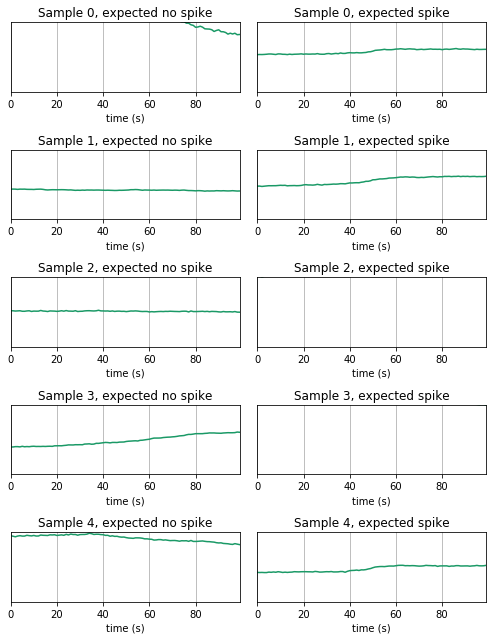

In [62]:
preds_nospike = model.sample(num_samples=5, did_spike=False)
preds_spike = model.sample(num_samples=5, did_spike=True)

# Plot the data where no spike was observed on the left,
# and the data where a spike was observed on the right.
fig = plt.figure(figsize=(7, 9))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plot_sample(calcium=preds_nospike[i], t_start=0, t_end=99, sampling_rate=1)
    plt.title('Sample %d, expected no spike' % i)
    plt.subplot(5, 2, 2 * i + 2);
    plot_sample(calcium=preds_spike[i], t_start=0, t_end=99, sampling_rate=1)
    plt.title('Sample %d, expected spike' % i)

plt.tight_layout()
plt.show()